<a href="https://colab.research.google.com/github/unrebby/data/blob/main/homework_practice_06_bvd_Antonova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.25603236064345

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    preds_ = np.zeros(X.shape[0])
    squares_ = np.zeros(X.shape[0])
    counts_ = np.zeros(X.shape[0])
    losses_ = np.zeros(X.shape[0])

    for i in range(num_runs):
      inds_ = np.random.choice(X.shape[0], size=X.shape[0])
      oob_ = list(set(np.arange(X.shape[0])) - set(inds_))
      regressor.fit(X[inds_], y[inds_])
      pred_ = regressor.predict(X[oob_])

      preds_[oob_] += pred_
      squares_[oob_] += pred_ ** 2
      counts_[oob_] += 1
      losses_[oob_] += (y[oob_] - pred_) ** 2

    preds_ /= counts_
    squares_ /= counts_
    losses_ /= counts_
    return ((preds_ - y) ** 2).mean(), (squares_ - preds_ ** 2).mean(), losses_.mean()
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [9]:
mthds_ = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor()]

for method_now in mthds_:
  bias_, variance_, error_ = compute_biase_variance(method_now, X, y)
  print(method_now, ':')
  print('bias: ', bias_)
  print('variance: ', variance_)
  print('error: ', error_, '\n')

LinearRegression() :
bias:  23.712883066623192
variance:  0.9245442558206949
error:  24.637427322443912 

DecisionTreeRegressor() :
bias:  10.250837956145139
variance:  12.964745051252692
error:  23.215583007397793 

RandomForestRegressor() :
bias:  10.705978254403558
variance:  2.227392745152362
error:  12.933370999555915 



__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Проанализируем первую модель: у линейной регрессии мы получили высокий bias и достаточно низкий variance, что и ожидалось в теории (линейные модели не особо чувствительны к изменениям в обучающей выборке, нет разнообразия алгоритмов, только линейнаые зависимости). 

Следующая модель: решающее дерево дало нам относительно ниизкий bias и высокий variance, как и ожидалось (деревья могут вычислять более сложные зависимости, подстраиваются под обучающую выборку и чувствительны к изменениям в ней).

Третья модель: случайный лес выдал низкий bias (как у деревьев), низкий variance (как у линейной регрессии) и низкий error (по сравнению с двумя предыдущими моделями), то есть наилучшую комбинацию значений (так происходит из-за того, что случайный лес не так сильно подстраивается под обучающую выборку, как решающее дерево, но при этом сохраняет bias, а variance стал значительно ниже (случайный лес в каждой вершине выбирает набор признаков из всех, по которым идёт разбиение)).

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Из теории: беггинг не меняет смещение и уменьшает разброс до в n раз.

На практике: линейная регрессия - значения смещения и разброса практически не изменились (так как они сильно коррелированы); решающее дерево - значение смещения не поменялись, разброс явно уменьшился, и error также уменьшился (так как модели некоррелированы, но не настолько, как предполагает теория, так как в нашем примере n равно 10, а разброс уменьшился примерно в 13 : 3.5 = 4 раза); случайный лес - значения также практически не изменились.

In [10]:
from sklearn.ensemble import BaggingRegressor

In [11]:
for method_now in mthds_:
  bias_, variance_, error_ = compute_biase_variance(BaggingRegressor(method_now), X, y)
  print(method_now, ' + bagging:')
  print('bias: ', bias_)
  print('variance: ', variance_)
  print('error: ', error_, '\n')

LinearRegression()  + bagging:
bias:  23.737751215140968
variance:  1.0245597529270452
error:  24.76231096806795 

DecisionTreeRegressor()  + bagging:
bias:  10.74428141880955
variance:  3.3491838740812385
error:  14.093465292890768 

RandomForestRegressor()  + bagging:
bias:  11.694670788429608
variance:  1.3937702242470031
error:  13.088441012676668 



### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [12]:
import seaborn as sns

In [13]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    inds_test = np.random.choice(X.shape[0], size=num_test_objects)
    inds_train = list(set(np.arange(X.shape[0])) - set(inds_test))
    X_train, y_train = X[inds_train], y[inds_train]
    X_test, y_test = X[inds_test], y[inds_test]

    x_ = np.arange(num_test_objects)
    for i in range(num_runs):
      inds_train_now = np.random.choice(X_train.shape[0], size=X_train.shape[0])

      regressor.fit(X_train[inds_train_now], y_train[inds_train_now])
      pred_ = regressor.predict(X_test)

      sns.scatterplot(x=x_, y=pred_, color='green')

    sns.scatterplot(x=x_, y=y_test, color='black', label='correct answer')
    plt.xlabel('test objects')
    plt.ylabel('predictions')
    plt.title(title)
    plt.legend()
    return


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [14]:
mthds_ = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor()]

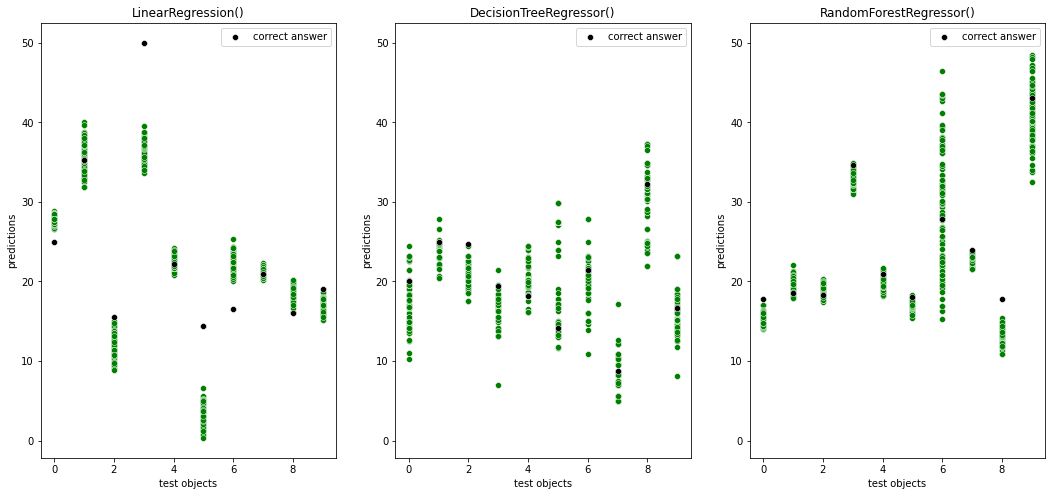

In [15]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 8))
i = 1
for method_now in mthds_:
  ax[i - 1] = plt.subplot(1, 3, i, sharey=ax[0])
  plot_predictions(method_now, X, y, title=method_now)
  i += 1

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Проанализируем первую модель: у линейной регрессии мы наблюдаем, что все предсказания (зелёные) находятся близко друг к другу, что символизирует низкий разброс; также можно заметить, что итоговые правильные предсказания (чёрные) находятся далеко от средних (зелёных), это значит, что у этой модели высокое смещение. Таким образом, мы снова подтвердили теорию, которую выявили выше.

Следующая модель: решающее дерево дало нам огромный разброс, так как предсказания находятся на большом расстоянии друг от друга (зелёные); смещение получилось низким, так как правильные предсказания находятся примерно по центру предсказаний. Тут тоже теория подтвердилась.

Третья модель: случайный лес снова выдаёт лучшие результаты (как и ожидалось), 
на графике видно низкий разброс (все зелёные точки сгруппированы рядом) и низкое смещение (чёрные точки - правильные предсказания - не сильно отделяются от полученных в процессе обучения). Также все сошлось с теорией.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [16]:
bias_max_depth = []
bias_max_features = []

variance_max_depth = []
variance_max_features = []

In [17]:
for i in range(10):
  max_depth_now = i + 1
  bias_, variance_, error_ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth_now), X, y)
  bias_max_depth.append(bias_)
  variance_max_depth.append(variance_)

In [18]:
for i in range(X.shape[1]):
  max_features_now = i + 1
  bias_, variance_, error_ = compute_biase_variance(DecisionTreeRegressor(max_features=max_features_now), X, y)
  bias_max_features.append(bias_)
  variance_max_features.append(variance_)

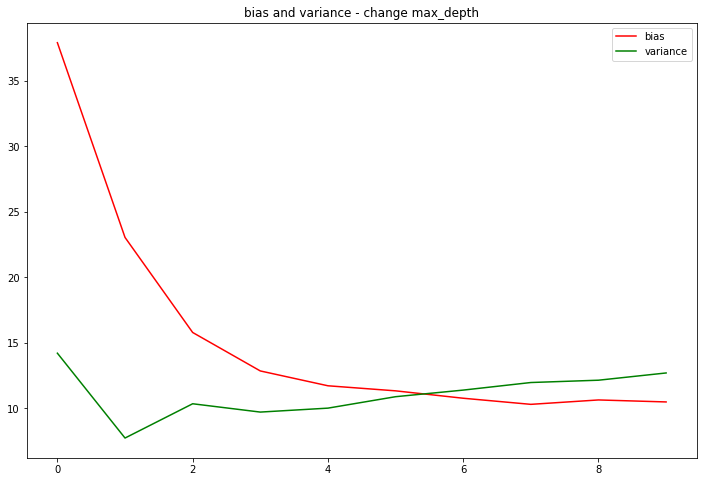

In [32]:
plt.subplots(figsize=(12, 8))
plt.plot(bias_max_depth, color='red', label='bias')
plt.plot(variance_max_depth, color='green', label='variance')
plt.title('bias and variance - change max_depth')
plt.legend()

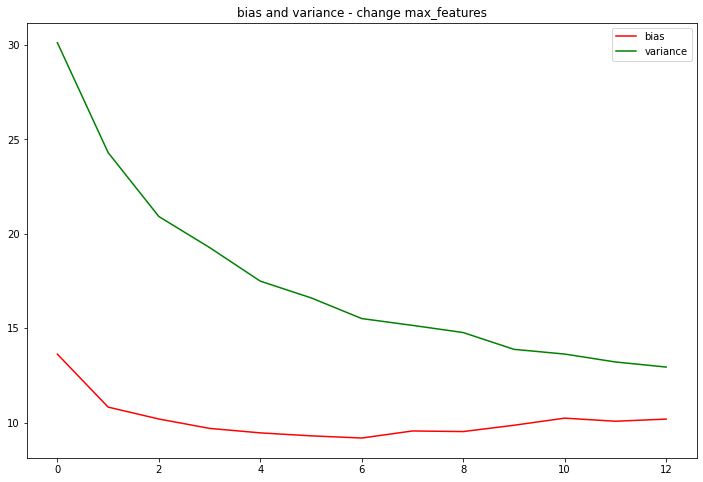

In [33]:
plt.subplots(figsize=(12, 8))
plt.plot(bias_max_features, color='red', label='bias')
plt.plot(variance_max_features, color='green', label='variance')
plt.title('bias and variance - change max_features')
plt.legend()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

In [22]:
bias_rand_for = []
bias_xgboost = []

variance_rand_for = []
variance_xgboost = []

In [23]:
for i in range(10):
  n_est_now = 2 ** (i + 1)
  bias_, variance_, error_ = compute_biase_variance(RandomForestRegressor(n_estimators=n_est_now), X, y, num_runs=200)
  bias_rand_for.append(bias_)
  variance_rand_for.append(variance_)

In [24]:
for i in range(10):
  n_est_now = 2 ** (i + 1)
  bias_, variance_, error_ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_est_now), X, y, num_runs=200)
  bias_xgboost.append(bias_)
  variance_xgboost.append(variance_)

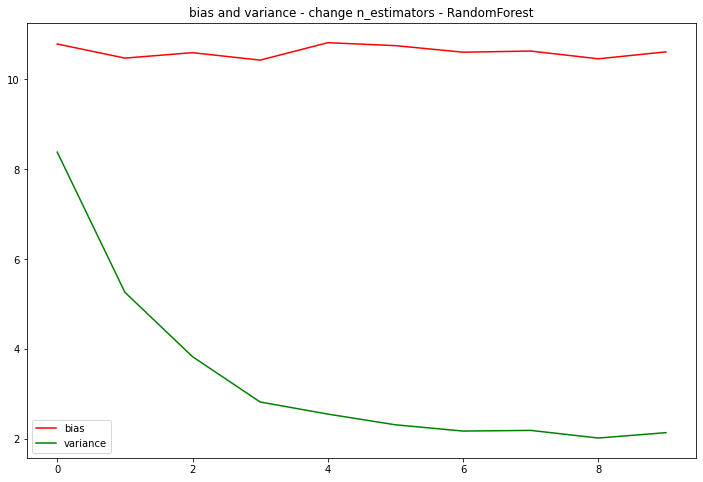

In [34]:
plt.subplots(figsize=(12, 8))
plt.plot(bias_rand_for, color='red', label='bias')
plt.plot(variance_rand_for, color='green', label='variance')
plt.title('bias and variance - change n_estimators - RandomForest')
plt.legend()

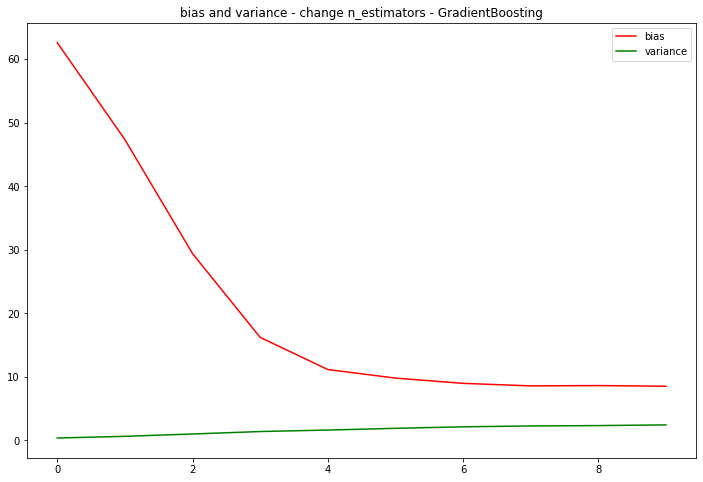

In [35]:
plt.subplots(figsize=(12, 8))
plt.plot(bias_xgboost, color='red', label='bias')
plt.plot(variance_xgboost, color='green', label='variance')
plt.title('bias and variance - change n_estimators - GradientBoosting')
plt.legend()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

bias variance

1. *График зависимости смещения и разброса от гиперпараметра решающего дерева max_depth* : bias монотонно падает, variance в начале графика немного падает, а потом растёт: при увеличении максимальной глубины дерева увеличивается способность дерева подстроиться под обучающую выборку => bias падает (в какой-то момент он практически перестаёт меняться, так как какой-то граничной константной глубины дерева уже достаточно, чтоб подогнаться под обучающую выборку); variance растёт, так как при увеличении глубины усложняется сама модель, и появляется разнообразие ответов модели.

2. *График зависимости смещения и разброса от гиперпараметра решающего дерева max_features* : bias монотонно падает, variance также: чем меньше этот параметр, тем меньше признаков есть у модели на обучение, а значит прогноз она будет давать, основываясь только на них => разброс значений вырастет (так как мало признаков, чтобы выдать правильный результат); смещение не особо сильно мееняется.

3. *График зависимости смещения и разброса от n_estimators для случайного леса* : bias практически не меняется, variance монотонно падает: мы увеличиваем количество деревьев в случайном лесу, из теории - чем больше это число, тем меньше разброс, при этом смещение не изменяется; это и происходит (смещение практически константное, разброс уменьшается).

4. *График зависимости смещения и разброса от n_estimators для градиентного бустинга* : bias монотонно падает, variance практически не меняется (немного растёт): увеличивая параметр, мы позволяем достраивать больше моделей, поэтому чем больше это число, тем сильнее мы можем улучшить (уточнить) общую модель => bias уменьшается, а variance немного растёт, так как мы позволяем модели уточнять пресказания настолько, что может произойти переобучение.



__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__ в ожидании новой домашки..

In [41]:
from google.colab import files
from IPython.display import Image

png_ = files.upload()
png__ = files.upload()

Saving photo_.jpg to photo_.jpg


Saving photo__.jpg to photo__.jpg


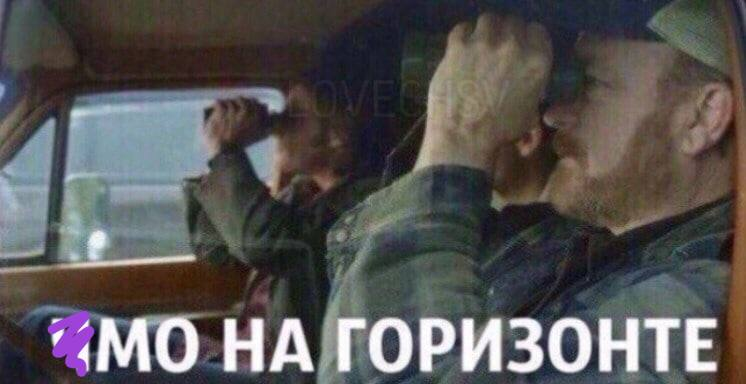

In [39]:
Image('photo_.jpg', height = 500)

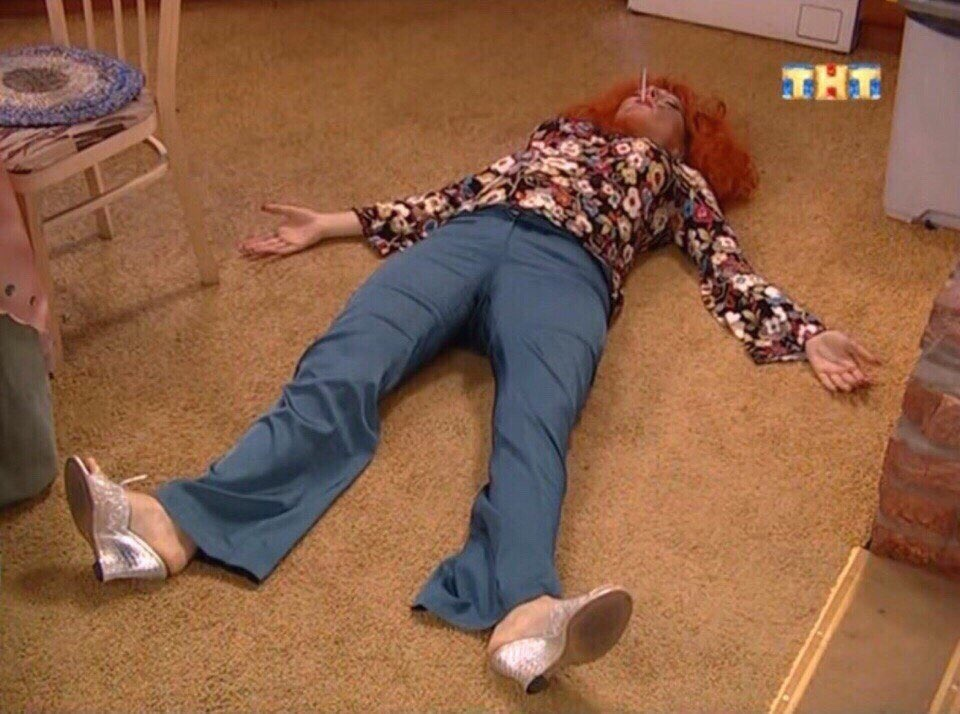

In [40]:
Image('photo__.jpg', height = 500)